In [1]:
import cv2
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization, LayerNormalization
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-15 08:30:36.954633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 08:30:36.954736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 08:30:37.077721: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# def remove_checkpoints(dir_path):
#     for root, dirs, files in os.walk(dir_path):
#         if '.ipynb_checkpoints' in dirs:
#             checkpoint_path = os.path.join(root, '.ipynb_checkpoints')
#             shutil.rmtree(checkpoint_path)
#             print(f"Removed: {checkpoint_path}")
def remove_checkpoints_and_tokenize_files(dir_path):
    for root, dirs, files in os.walk(dir_path):
        # Menghapus direktori .ipynb_checkpoints
        if '.ipynb_checkpoints' in dirs:
            checkpoint_path = os.path.join(root, '.ipynb_checkpoints')
            shutil.rmtree(checkpoint_path)
            print(f"Removed directory: {checkpoint_path}")

        # Menghapus file _tokenize.txt
#         for file in files:
#             if file == '_tokenization.txt':
#                 tokenize_file_path = os.path.join(root, file)
#                 shutil.rmtree(tokenize_file_path)
#                 print(f"Removed file: {tokenize_file_path}")

In [3]:
train_dir = remove_checkpoints_and_tokenize_files("/kaggle/input/berry-coffee/train")
test_dir = remove_checkpoints_and_tokenize_files("/kaggle/input/berry-coffee/test")
val_dir = remove_checkpoints_and_tokenize_files("/kaggle/input/berry-coffee/valid")

train_dir = "/kaggle/input/berry-coffee/train"
test_dir = "/kaggle/input/berry-coffee/test"
val_dir = "/kaggle/input/berry-coffee/valid"


In [4]:
label = []
count = []
for dir in os.listdir(train_dir):
  dir_path = os.path.join(train_dir, dir)
  if '_tokenization.txt' in dir:
    continue
  label.append(dir)
  count.append(len(os.listdir(dir_path)))
fig = px.bar(x=label, y=count)
fig.show()

In [5]:
label = []
count = []
for dir in os.listdir(test_dir):
  dir_path = os.path.join(test_dir, dir)
  if '_tokenization.txt' in dir:
    continue
  label.append(dir)
  count.append(len(os.listdir(dir_path)))
fig = px.bar(x=label, y=count)
fig.show()

In [6]:
label = []
count = []
for dir in os.listdir(val_dir):
  dir_path = os.path.join(val_dir, dir)
  if '_tokenization.txt' in dir:
    continue
  label.append(dir)
  count.append(len(os.listdir(dir_path)))
fig = px.bar(x=label, y=count)
fig.show()

In [7]:
def enhance_contrast_and_brightness(image, brightness=30):
    # Konversi ke LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # Membagi channels
    l, a, b = cv2.split(lab)
    
    # Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    
    # Adjust brightness
    l = cv2.add(l, np.array([brightness]))
    
    # Menggabungkan kembali channels
    merged = cv2.merge((l, a, b))
    
    # Konversi kembali ke BGR
    enhanced = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    
    return enhanced

In [8]:
def process_images(base_input_dir, base_output_dir):
    if not os.path.exists(base_output_dir):
        os.makedirs(base_output_dir)

    for category in os.listdir(base_input_dir):
        input_dir = os.path.join(base_input_dir, category)
        output_dir = os.path.join(base_output_dir, category)

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for filename in os.listdir(input_dir):
            
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)
            
            if category == 'Coffee__Berry_borer' or category == 'Coffee__Damaged_bean':
                # Enhance contrast and brightness
                image = enhance_contrast_and_brightness(image)
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Zoom gambar sekitar 40%
            scale_percent = 140  # Persentase zoom (140% untuk melakukan zoom sekitar 40%)
            width = int(image.shape[1] * scale_percent / 100)
            height = int(image.shape[0] * scale_percent / 100)
            dim = (width, height)
            image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

            # Red color boundaries [B, G, R]
            lower = [np.mean(image[:, :, i] - np.std(image[:, :, i]) / 3) for i in range(3)]
            upper = [250, 250, 250]

            # Create NumPy arrays from the boundaries
            lower = np.array(lower, dtype="uint8")
            upper = np.array(upper, dtype="uint8")

            # Find the colors within the specified boundaries and apply
            mask = cv2.inRange(image, lower, upper)
            output = cv2.bitwise_and(image, image, mask=mask)

            ret, thresh = cv2.threshold(mask, 40, 255, 0)

            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            if len(contours) != 0:
                # Draw in blue the contours that were found
                cv2.drawContours(output, contours, -1, 255, 3)

                # Find the biggest contour (c) by the area
                c = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(c)

                # Draw the biggest contour (c) in green
                cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 5)

            foreground = image[y:y + h, x:x + w]

            # Save the resulting image
            result_image_path = os.path.join(output_dir, filename)
            cv2.imwrite(result_image_path, cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))

#             # Optionally, you can display the images as you did previously
#             plt.figure(figsize=(20, 4))
#             plt.subplot(1, 3, 1), plt.imshow(image), plt.title("Input")
#             plt.subplot(1, 3, 2), plt.imshow(output), plt.title("All Contours")
#             plt.subplot(1, 3, 3), plt.imshow(foreground), plt.title("Output")
#             plt.show()
#             print(foreground.shape)

# Example usage
base_input_directory = '/kaggle/input/berry-coffee/train'
base_output_directory = '/kaggle/working/train'
process_images(base_input_directory, base_output_directory)

In [9]:
base_input_directory = '/kaggle/input/berry-coffee/valid'
base_output_directory = '/kaggle/working/valid'
process_images(base_input_directory, base_output_directory)

In [10]:
training_dir = "/kaggle/working/train"
testing_dir = "/kaggle/working/test"
validation_dir = "/kaggle/working/valid"

In [11]:
label = []
count = []
for dir in os.listdir(training_dir):
  dir_path = os.path.join(training_dir, dir)
  if '_tokenization.txt' in dir:
    continue
  label.append(dir)
  count.append(len(os.listdir(dir_path)))
fig = px.bar(x=label, y=count)
fig.show()

In [12]:
train_datagen = ImageDataGenerator(rotation_range=0.4,
                                   rescale = 1./255,
                                   shear_range=0.2,
                                   zoom_range=0.5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical',
        shuffle=True)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical',
        shuffle=False)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical',
        shuffle=False)

Found 1469 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 420 images belonging to 3 classes.


In [14]:
model = Sequential([
        Conv2D(512, (5, 5), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(3, 3),
        BatchNormalization(),
        LayerNormalization(epsilon=1e-6),
        Dropout(0.3),
        Conv2D(256, (5, 5), activation='relu'),
        MaxPooling2D(3, 3),
        BatchNormalization(),
        LayerNormalization(epsilon=1e-6),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(3, activation='softmax')
    ])
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 512)  │        38,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 73, 73, 512)    │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73, 73, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 256)    │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 23, 23, 256)    │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 135424)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    69,337,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,790,275 (277.67 MB)

 Trainable params: 72,788,739 (277.67 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [16]:
def scheduler(epoch, lr):
  lr0=1e-5
  if epoch >=5 and epoch <10:
    return lr0*1e-1
  elif epoch >=11 and epoch <20:
    return lr0*1e-2
  elif epoch >=21 and epoch <30:
    return lr0*1e-3
  else:
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [17]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    callbacks=[callback])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

I0000 00:00:1718440369.179259      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718440369.198886      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 51/147 ━━━━━━━━━━━━━━━━━━━━ 1:12 757ms/step - accuracy: 0.6750 - loss: 0.9900

W0000 00:00:1718440407.049713      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7445 - loss: 0.7497

W0000 00:00:1718440422.799513      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 92s 378ms/step - accuracy: 0.7449 - loss: 0.7484 - val_accuracy: 0.4976 - val_loss: 1.7131 - learning_rate: 1.0000e-05
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step - accuracy: 0.8265 - loss: 0.4368 - val_accuracy: 0.9310 - val_loss: 0.2524 - learning_rate: 1.0000e-05
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 163ms/step - accuracy: 0.8794 - loss: 0.3352 - val_accuracy: 0.9238 - val_loss: 0.2344 - learning_rate: 1.0000e-05
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 163ms/step - accuracy: 0.8785 - loss: 0.3263 - val_accuracy: 0.8381 - val_loss: 0.4599 - learning_rate: 1.0000e-05
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - accuracy: 0.9214 - loss: 0.2625 - val_accuracy: 0.6738 - val_loss: 0.7347 - learning_rate: 1.0000e-05
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - accuracy: 0.9134 - loss: 0.2111 - val_accuracy: 0.9524 - val_loss: 0.1570 - learning_rate: 1.0000e-06
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - 

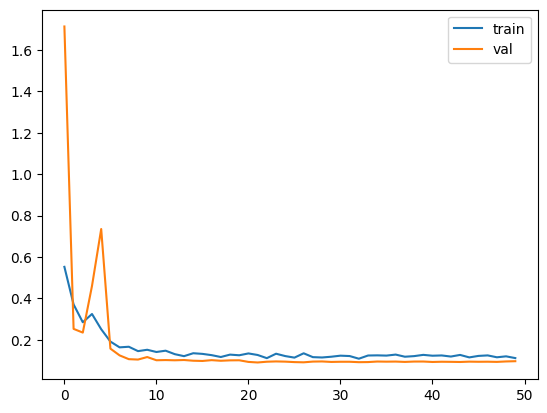

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

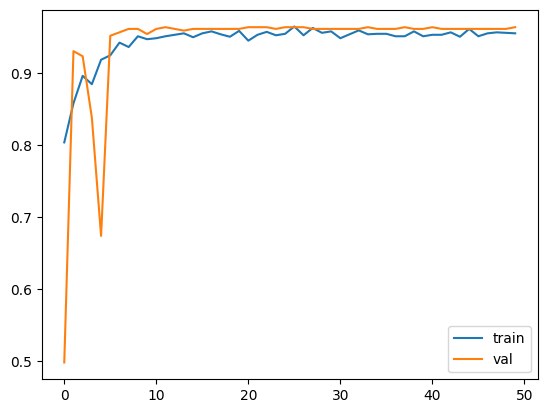

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [20]:
model.save("berryv1.9.h5")

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

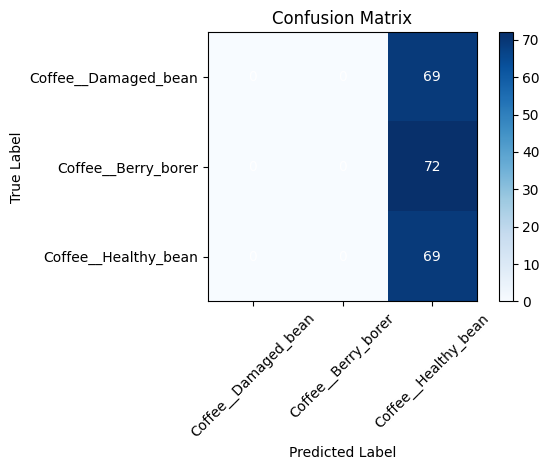

In [22]:
# Daftar nama kelas
classes = ['Coffee__Damaged_bean', 'Coffee__Berry_borer', 'Coffee__Healthy_bean']

# Inisialisasi label encoder
label_encoder = LabelEncoder()

# Inisialisasi list untuk menyimpan true labels dan predicted labels
true_labels = []
predicted_labels = []

# Loop melalui setiap subfolder kelas di direktori test
for class_name in classes:
    class_dir = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_dir):
        # Mendapatkan true label dari nama subfolder
        true_label = class_name
        true_labels.append(true_label)

        # Memuat dan melakukan preprocessing pada gambar
        img_path = os.path.join(class_dir, image_name)
        img = image.load_img(img_path, target_size=(224, 224, 3))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normalisasi

        # Lakukan prediksi pada gambar
        predicted_label = model.predict(img_array)
        predicted_label = classes[np.argmax(predicted_label)]
        predicted_labels.append(predicted_label)

# Encode true labels
true_labels_encoded = label_encoder.fit_transform(true_labels)

# Encode predicted labels
predicted_labels_encoded = label_encoder.transform(predicted_labels)

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_labels_encoded, predicted_labels_encoded)

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i][j]), ha='center', va='center', color='white')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Inspired by ConvNext Tiny

In [23]:
from tensorflow.keras import layers, models

In [24]:
def convnext_tiny(input_shape=(224, 224, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(96, kernel_size=4, strides=4)(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Stage 1
    for _ in range(3):
        x = residual_block(x, 96)
    
    # Stage 2
    x = layers.Conv2D(192, kernel_size=2, strides=2)(x)
    for _ in range(3):
        x = residual_block(x, 192)

    # Stage 3
    x = layers.Conv2D(384, kernel_size=2, strides=2)(x)
    for _ in range(9):
        x = residual_block(x, 384)

    # Stage 4
    x = layers.Conv2D(768, kernel_size=2, strides=2)(x)
    for _ in range(3):
        x = residual_block(x, 768)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=7, padding='same', groups=filters)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dense(4 * filters)(x)
    x = layers.Dense(filters)(x)
    return layers.Add()([x, shortcut])

# Create the model
model2 = convnext_tiny()

# Print the summary
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │      4,704 │ input_layer_1[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 56, 56,    │        192 │ conv2d_2[0][0]    │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │      4,800 │ layer_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 56, 56,    │        192 │ conv2d_3[0][0]    │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 56, 56,    │     37,248 │ layer_normalizat… │
│                     │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 56, 56,    │     36,960 │ dense_3[0][0]     │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ dense_4[0][0],    │
│                     │ 96)               │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │      4,800 │ add[0][0]         │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 56, 56,    │        192 │ conv2d_4[0][0]    │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 56, 56,    │     37,248 │ layer_normalizat… │
│                     │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 56, 56,    │     36,960 │ dense_5[0][0]     │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 56, 56,    │          0 │ dense_6[0][0],    │
│                     │ 96)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │      4,800 │ add_1[0][0]       │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 56, 56,    │        192 │ conv2d_5[0][0]    │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 56, 56,    │     37,248 │ layer_normalizat… │
│                     │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 56, 56,    │     36,960 │ dense_7[0][0]   

 Total params: 27,814,467 (106.10 MB)

 Trainable params: 27,814,467 (106.10 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model2.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
history2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    callbacks=[callback])

Epoch 1/50
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:44:37 43s/step - accuracy: 0.1000 - loss: 1.5142

W0000 00:00:1718441789.491416      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441789.491852      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441789.492384      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441789.492815      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441789.493241      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441789.493652      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441789.494098      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441789.494545      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/147 ━━━━━━━━━━━━━━━━━━━━ 14s 333ms/step - accuracy: 0.2826 - loss: 1.4897

W0000 00:00:1718441823.766335      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441823.766736      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441823.767209      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441823.768270      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441823.768639      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441823.769098      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441823.769504      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441823.769889      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.2862 - loss: 1.4301

W0000 00:00:1718441833.272483      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441833.272780      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441833.273216      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441833.273626      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441833.274023      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441833.274392      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441833.274729      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718441833.275121      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 88s 310ms/step - accuracy: 0.2863 - loss: 1.4291 - val_accuracy: 0.3476 - val_loss: 1.2064 - learning_rate: 1.0000e-05
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 0.3661 - loss: 1.1394 - val_accuracy: 0.3357 - val_loss: 1.2427 - learning_rate: 1.0000e-05
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.3389 - loss: 1.1969 - val_accuracy: 0.3167 - val_loss: 1.2163 - learning_rate: 1.0000e-05
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.3191 - loss: 1.1624 - val_accuracy: 0.4048 - val_loss: 1.0757 - learning_rate: 1.0000e-05
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.3659 - loss: 1.1218 - val_accuracy: 0.3405 - val_loss: 1.0634 - learning_rate: 1.0000e-05
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.4457 - loss: 1.0589 - val_accuracy: 0.4048 - val_loss: 1.0615 - learning_rate: 1.0000e-06
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - 

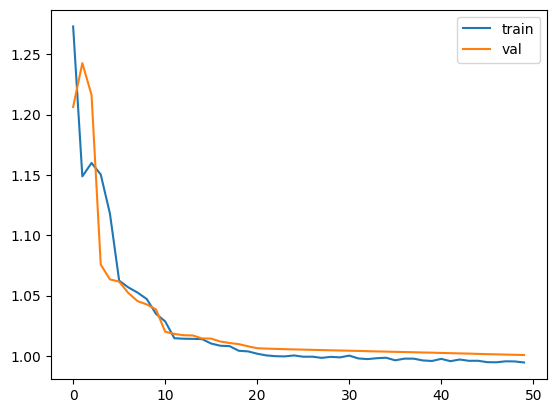

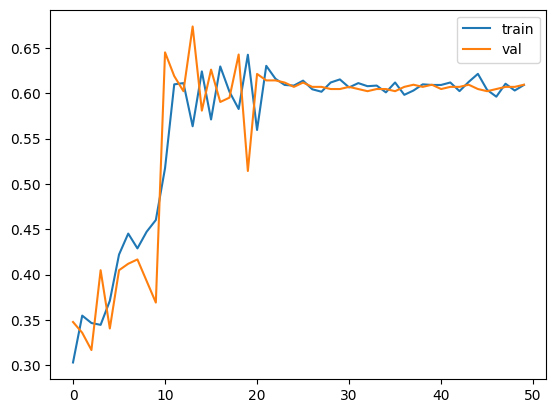

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [27]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.legend()
plt.show()
plt.figure()

plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='val')
plt.legend()
plt.show()
plt.figure()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


W0000 00:00:1718443072.636555      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718443072.637010      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718443072.637444      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718443072.638225      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718443072.638696      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718443072.639144      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718443072.639873      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718443072.640304      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

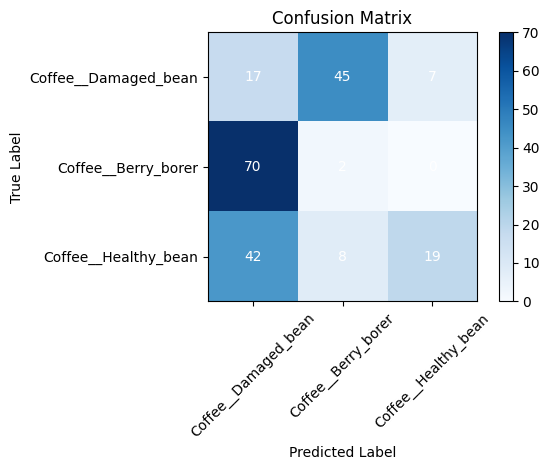

In [28]:
# Daftar nama kelas
classes = ['Coffee__Damaged_bean', 'Coffee__Berry_borer', 'Coffee__Healthy_bean']

# Inisialisasi label encoder
label_encoder = LabelEncoder()

# Inisialisasi list untuk menyimpan true labels dan predicted labels
true_labels = []
predicted_labels = []

# Loop melalui setiap subfolder kelas di direktori test
for class_name in classes:
    class_dir = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_dir):
        # Mendapatkan true label dari nama subfolder
        true_label = class_name
        true_labels.append(true_label)

        # Memuat dan melakukan preprocessing pada gambar
        img_path = os.path.join(class_dir, image_name)
        img = image.load_img(img_path, target_size=(224, 224, 3))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normalisasi

        # Lakukan prediksi pada gambar
        predicted_label = model2.predict(img_array)
        predicted_label = classes[np.argmax(predicted_label)]
        predicted_labels.append(predicted_label)

# Encode true labels
true_labels_encoded = label_encoder.fit_transform(true_labels)

# Encode predicted labels
predicted_labels_encoded = label_encoder.transform(predicted_labels)

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_labels_encoded, predicted_labels_encoded)

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i][j]), ha='center', va='center', color='white')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [29]:
model2.save("berry_conv1.1.h5")